In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
data = pd.read_csv("/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20241129.csv")

In [3]:
data.head(5)

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,11/01/2023,10536,8347,223,14072,0,48.0
4,11/09/2021,820,612,0,1283,0,11.0


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1918 non-null   object 
 1   Local Route   1918 non-null   int64  
 2   Light Rail    1918 non-null   int64  
 3   Peak Service  1918 non-null   int64  
 4   Rapid Route   1918 non-null   int64  
 5   School        1918 non-null   int64  
 6   Other         1898 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 105.0+ KB


**Data Preprocessing:**

In [7]:
# check for missing values
print(data.isnull().sum())

Date            0
Local Route     0
Light Rail      0
Peak Service    0
Rapid Route     0
School          0
Other           0
dtype: int64


In [12]:
print("Missing values in 'Other':", data['Other'].isnull().sum())

Missing values in 'Other': 0


In [11]:
# assign missing values in the 'Other' column with the median
data['Other'] = data['Other'].fillna(data['Other'].median())
print(data['Other'])

0        59.0
1        61.0
2        13.0
3        48.0
4        11.0
        ...  
1913     66.0
1914    113.0
1915     25.0
1916     19.0
1917     99.0
Name: Other, Length: 1918, dtype: float64


In [15]:
# convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
print(data['Date'])

0      2024-08-30
1      2023-09-15
2      2021-12-28
3      2023-01-11
4      2021-09-11
          ...    
1913   2023-01-19
1914   2023-08-16
1915   2022-01-10
1916   2020-05-04
1917   2023-07-26
Name: Date, Length: 1918, dtype: datetime64[ns]


In [17]:
# check and remove duplicate rows
data.drop_duplicates(inplace=True)

In [18]:
print(data.describe())


                      Date   Local Route    Light Rail  Peak Service  \
count                 1918   1918.000000   1918.000000   1918.000000   
mean   2022-02-13 12:00:00   9891.395203   7195.446298    179.581335   
min    2019-07-01 00:00:00      1.000000      0.000000      0.000000   
25%    2020-10-22 06:00:00   3044.500000   4463.500000      0.000000   
50%    2022-02-13 12:00:00  11417.000000   7507.000000    193.000000   
75%    2023-06-07 18:00:00  15517.500000  10008.250000    313.750000   
max    2024-09-29 00:00:00  21070.000000  15154.000000   1029.000000   
std                    NaN   6120.715714   3345.616428    156.532738   

        Rapid Route       School        Other  
count   1918.000000  1918.000000  1918.000000  
mean   12597.213243  2352.694995    43.355057  
min        0.000000     0.000000     0.000000  
25%     6383.000000     0.000000    15.000000  
50%    13106.500000   567.500000    40.000000  
75%    17924.750000  4914.000000    67.750000  
max    28678.00

***1.Insight : Analyse the dataset and provide 4 – 5 key insights ***

**Heatmap of Passenger Journeys Over Time**

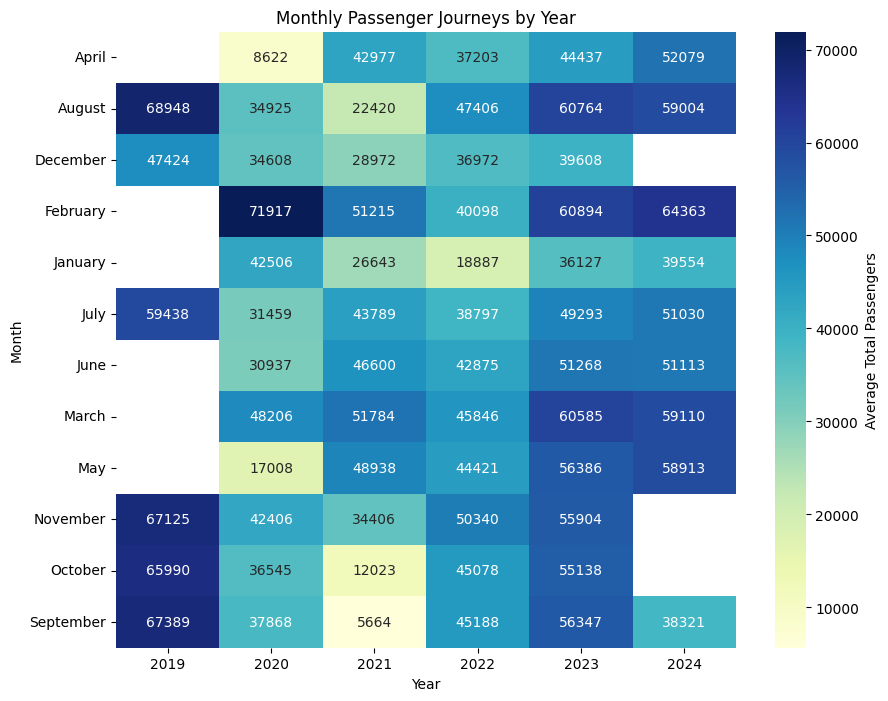

In [55]:
# Pivot table for heatmap visualization
heatmap_data = data.pivot_table(index=data.index.month_name(), columns=data.index.year, values='Total', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".0f", cbar_kws={'label': 'Average Total Passengers'})
plt.title('Monthly Passenger Journeys by Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


**Passenger Journeys Over Time: Service Type Trends and Seasonal Variations**

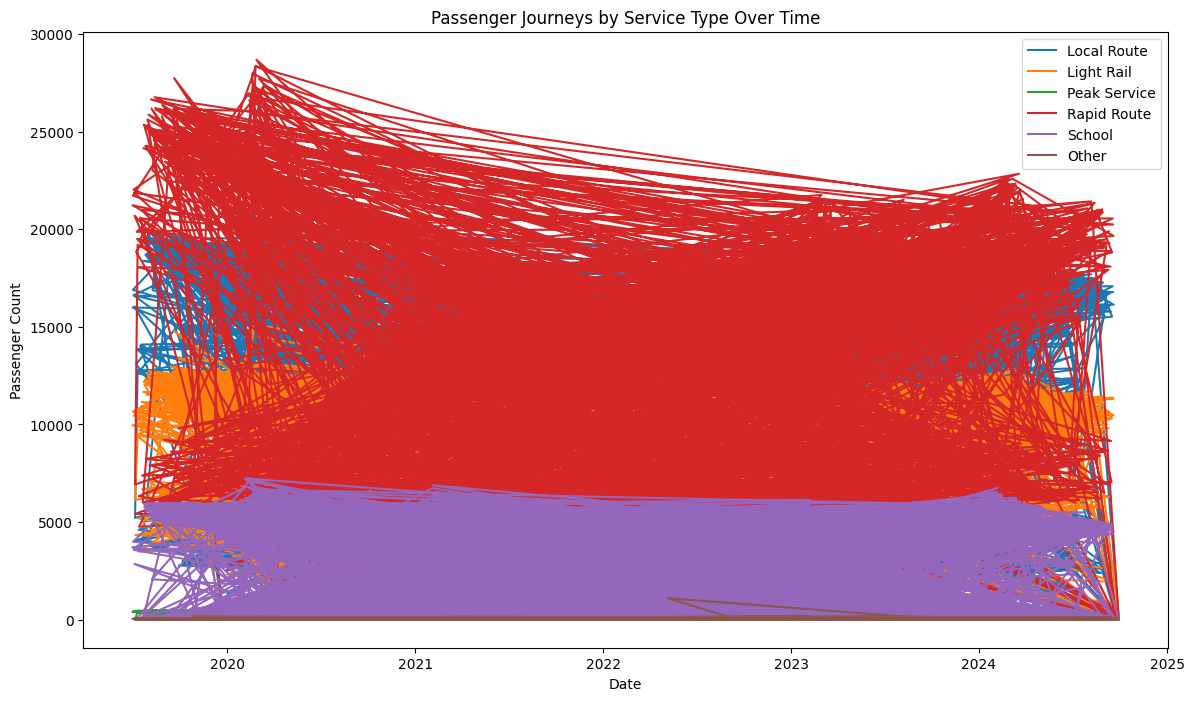

In [19]:
# plot time-series data for each service type
plt.figure(figsize=(14, 8))
for column in data.columns[1:]:
    plt.plot(data['Date'], data[column], label=column)

plt.title('Passenger Journeys by Service Type Over Time')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()


**Correlation Analysis of Service Types: Identifying Relationships in Passenger Journeys**

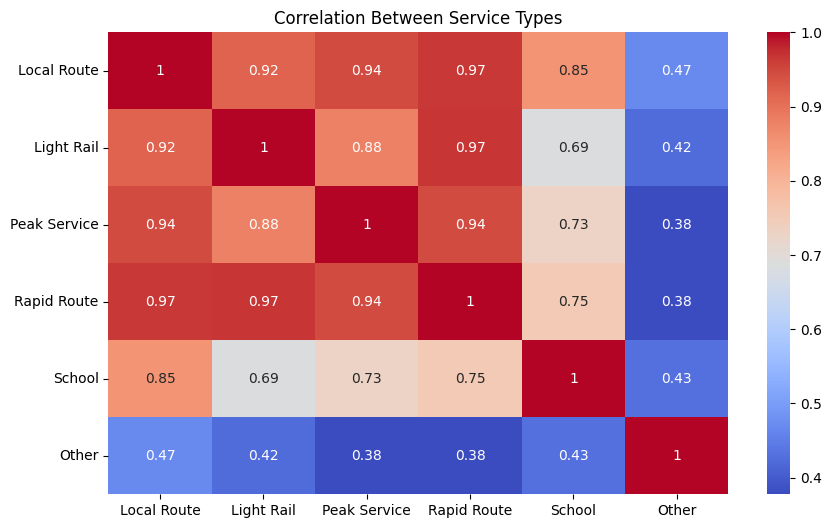

In [20]:
# correlation matrix
correlation_matrix = data.iloc[:, 1:].corr()

# visualise the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Service Types')
plt.show()


**7-Day Rolling Averages: Smoothing Passenger Journey Trends for Better Insights**

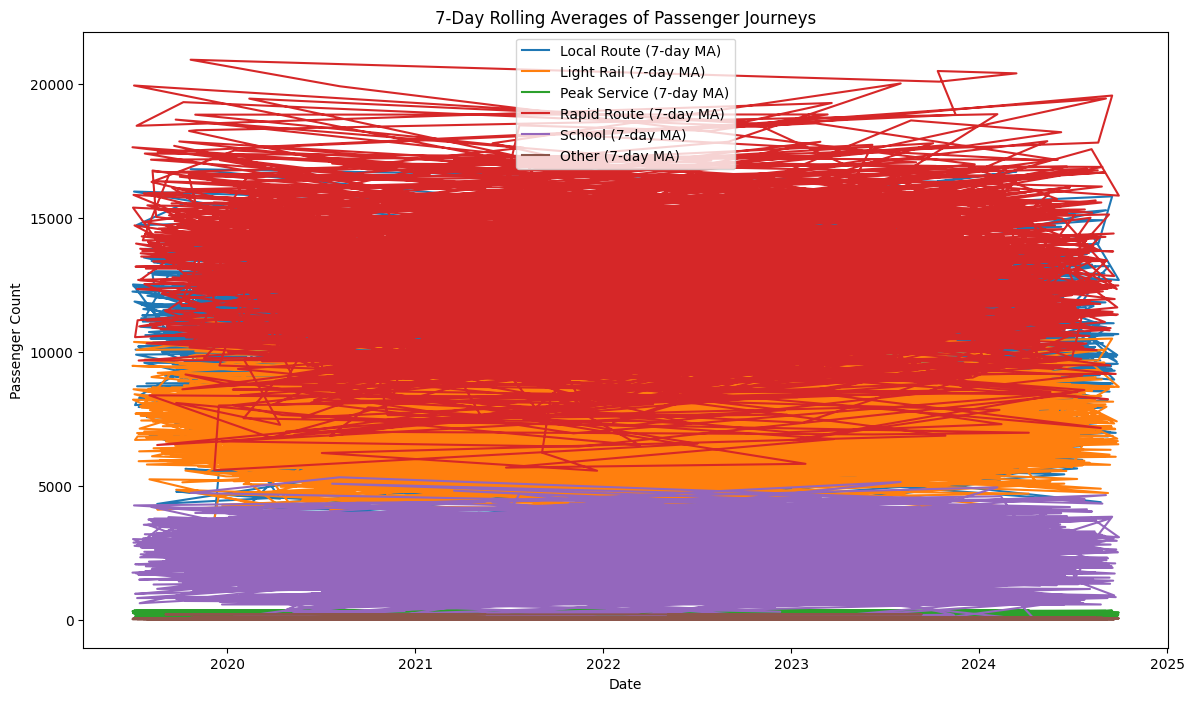

In [21]:
# calculate and plot rolling averages (7-day window)
data.set_index('Date', inplace=True)
rolling_avg = data.rolling(window=7).mean()

plt.figure(figsize=(14, 8))
for column in rolling_avg.columns:
    plt.plot(rolling_avg.index, rolling_avg[column], label=f'{column} (7-day MA)')

plt.title('7-Day Rolling Averages of Passenger Journeys')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()


**Service Contribution Analysis: Understanding the Share of Each Service in Total Passenger Journeys**

In [30]:
# compute daily totals and percentage contributions
data['Total'] = data.iloc[:, 1:].sum(axis=1)
service_avg_percentage = (data.iloc[:, 1:6].sum() / data['Total'].sum()) * 100


In [31]:
# display the percentage contributions
print(service_avg_percentage)

Light Rail      32.166606
Peak Service     0.802802
Rapid Route     56.314728
School          10.517515
Other            0.193815
dtype: float64


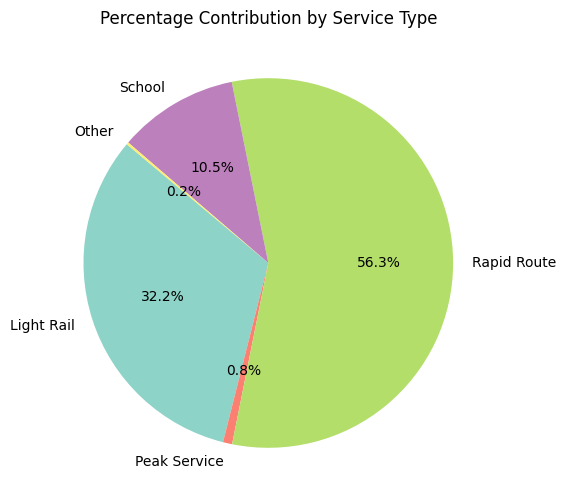

In [32]:
# visualize with a pie chart
plt.figure(figsize=(8, 6))
service_avg_percentage.plot(kind='pie', autopct='%1.1f%%', startangle=140, colormap='Set3')
plt.title('Percentage Contribution by Service Type')
plt.ylabel('')
plt.show()

**Average Percentage Contribution of Each Service Type: Identifying Key Services and Opportunities for Optimization**

In [34]:
# Compute daily total passenger journeys
data['Total'] = data.iloc[:, 1:].sum(axis=1)

# Calculate percentage contribution for each service type
for column in data.columns[1:-1]:  # Exclude 'Date' and 'Total'
    data[f'{column}_Percentage'] = (data[column] / data['Total']) * 100

In [35]:
print(data.head())

            Local Route  Light Rail  Peak Service  Rapid Route  School  Other  \
Date                                                                            
2024-08-30        16436       10705           225        19026    3925   59.0   
2023-09-15        15499       10671           267        18421    4519   61.0   
2021-12-28         1756        2352             0         3775       0   13.0   
2023-01-11        10536        8347           223        14072       0   48.0   
2021-09-11          820         612             0         1283       0   11.0   

            Cluster    Total  Light Rail_Percentage  Peak Service_Percentage  \
Date                                                                           
2024-08-30        2  67884.0              15.769548                 0.331448   
2023-09-15        2  67882.0              15.719926                 0.393330   
2021-12-28        1  12282.0              19.149976                 0.000000   
2023-01-11        0  45380.0    

In [36]:
# analyze average percentage contribution for each service type
percentage_columns = [col for col in data.columns if 'Percentage' in col]
average_contributions = data[percentage_columns].mean().sort_values(ascending=False)

print("\nAverage Percentage Contribution of Each Service Type:")
print(average_contributions)


Average Percentage Contribution of Each Service Type:
Rapid Route_Percentage     28.553567
Light Rail_Percentage      17.124034
School_Percentage           3.777812
Peak Service_Percentage     0.309977
Other_Percentage            0.227810
Cluster_Percentage          0.006801
dtype: float64


<ipython-input-37-7cd5b142c55e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_contributions.values, y=average_contributions.index, palette="viridis")


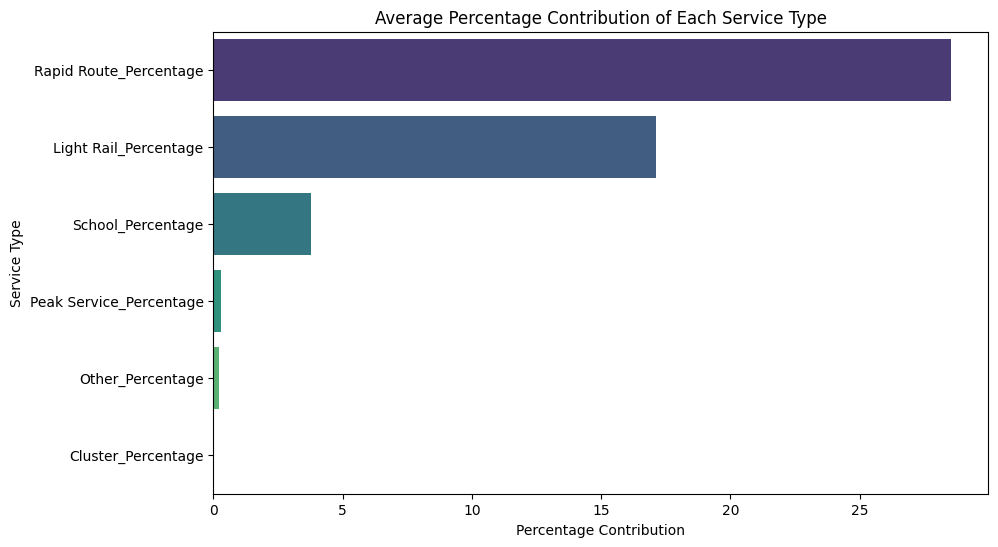

In [37]:
# visualize the average percentage contributions
plt.figure(figsize=(10, 6))
sns.barplot(x=average_contributions.values, y=average_contributions.index, palette="viridis")
plt.title('Average Percentage Contribution of Each Service Type')
plt.xlabel('Percentage Contribution')
plt.ylabel('Service Type')
plt.show()

**Service Variability Analysis: Understanding the Fluctuations in Passenger Journeys**

In [38]:
# identify services with high variance in percentage contributions
variance_contributions = data[percentage_columns].std().sort_values(ascending=False)
print("\nStandard Deviation (Variability) in Percentage Contributions:")
print(variance_contributions)


Standard Deviation (Variability) in Percentage Contributions:
School_Percentage          4.024307
Light Rail_Percentage      3.496938
Rapid Route_Percentage     2.937260
Other_Percentage           2.169361
Peak Service_Percentage    0.230852
Cluster_Percentage         0.054397
dtype: float64


<ipython-input-39-2921258ace46>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=variance_contributions.values, y=variance_contributions.index, palette="mako")


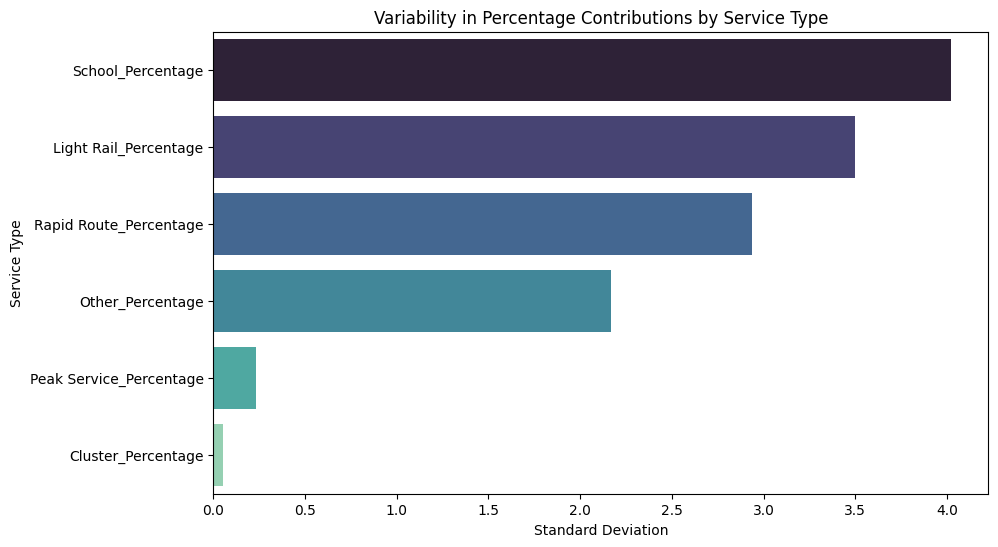

In [39]:
# visualize the variability
plt.figure(figsize=(10, 6))
sns.barplot(x=variance_contributions.values, y=variance_contributions.index, palette="mako")
plt.title('Variability in Percentage Contributions by Service Type')
plt.xlabel('Standard Deviation')
plt.ylabel('Service Type')
plt.show()

**Clustering Days Based on Service Usage Patterns: Identifying Demand Trends for Optimization(K-Means)**

In [22]:
# normalise data for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data.iloc[:, 1:])

In [23]:
# perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(normalized_data)

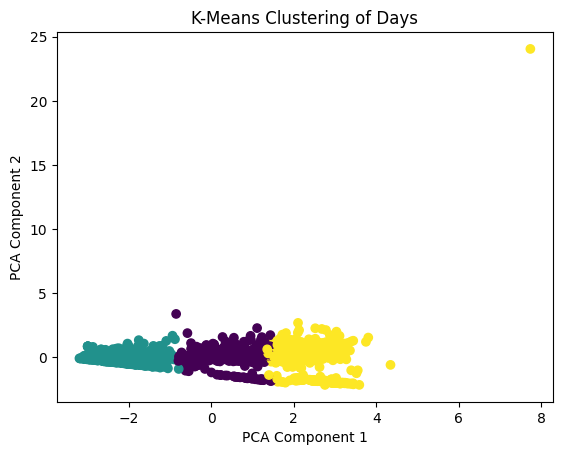

In [25]:
# visualize clusters using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['Cluster'], cmap='viridis')
plt.title('K-Means Clustering of Days')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

**ARIMA Forecasting of Local Route Passenger Journeys: Predicting Future Demand**

In [29]:
# ARIMA model for forecasting
train = data['Local Route'][:-365]
test = data['Local Route'][-365:]

model = ARIMA(train, order=(5, 1, 0))
arima_result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


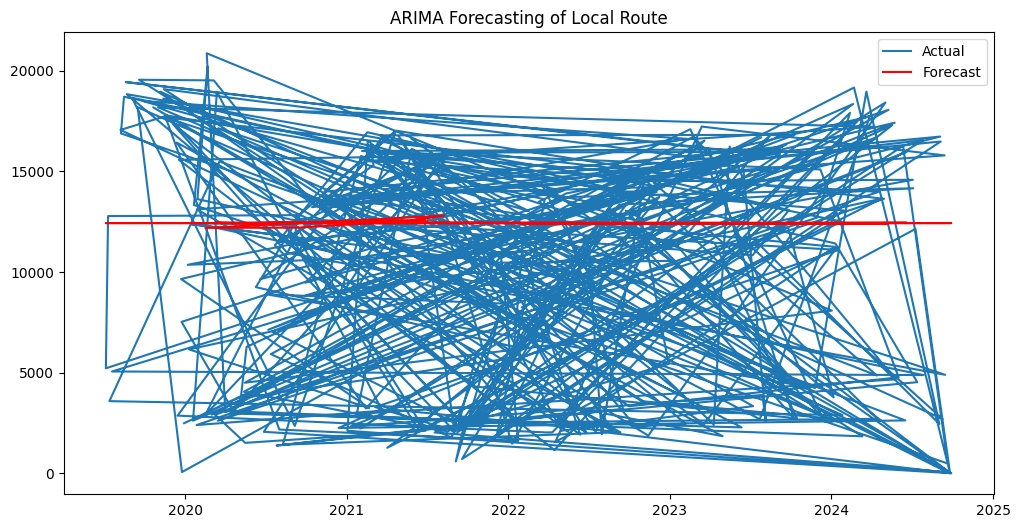

In [28]:
# Forecast
forecast = arima_result.forecast(steps=365)
plt.figure(figsize=(12, 6))
plt.plot(data.index[-365:], test, label='Actual')
plt.plot(data.index[-365:], forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecasting of Local Route')
plt.show()

***2.Forecast : Forecast the Local Route, Light Rail , Peak Service, Rapid Route, School (details about this field are in the dataset) for the next 7 days(ARIMA)***


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [42]:
# service types to forecast
service_types = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

# forecast results dictionary
forecast_results = {}

In [43]:
# to check stationarity
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is non-stationary. Differencing is recommended.")
    else:
        print("Series is stationary.")

for service in service_types:
    print(f"\nProcessing: {service}")

    check_stationarity(data[service])


Processing: Local Route
ADF Statistic: -44.4159526061123
p-value: 0.0
Series is stationary.

Processing: Light Rail
ADF Statistic: -11.372676807533027
p-value: 8.899766119330716e-21
Series is stationary.

Processing: Peak Service
ADF Statistic: -43.723800961760894
p-value: 0.0
Series is stationary.

Processing: Rapid Route
ADF Statistic: -44.25173719210157
p-value: 0.0
Series is stationary.

Processing: School
ADF Statistic: -44.7983379886376
p-value: 0.0
Series is stationary.


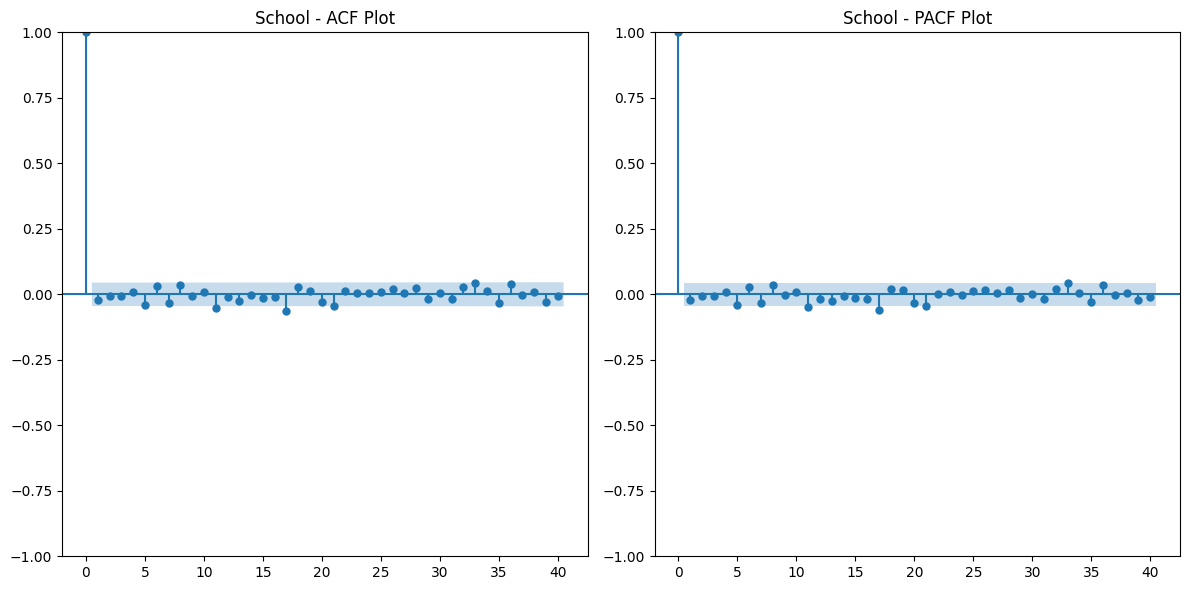

In [44]:
# plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(data[service].dropna(), lags=40, ax=plt.gca())
plt.title(f'{service} - ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(data[service].dropna(), lags=40, ax=plt.gca(), method='ywm')
plt.title(f'{service} - PACF Plot')
plt.tight_layout()
plt.show()

In [45]:
# based on ACF and PACF, fit ARIMA model
model = ARIMA(data[service], order=(5, 1, 0))  # Adjust (p, d, q) after inspecting plots
arima_result = model.fit()

# forecast for the next 7 days
forecast = arima_result.forecast(steps=7)
forecast_results[service] = forecast


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

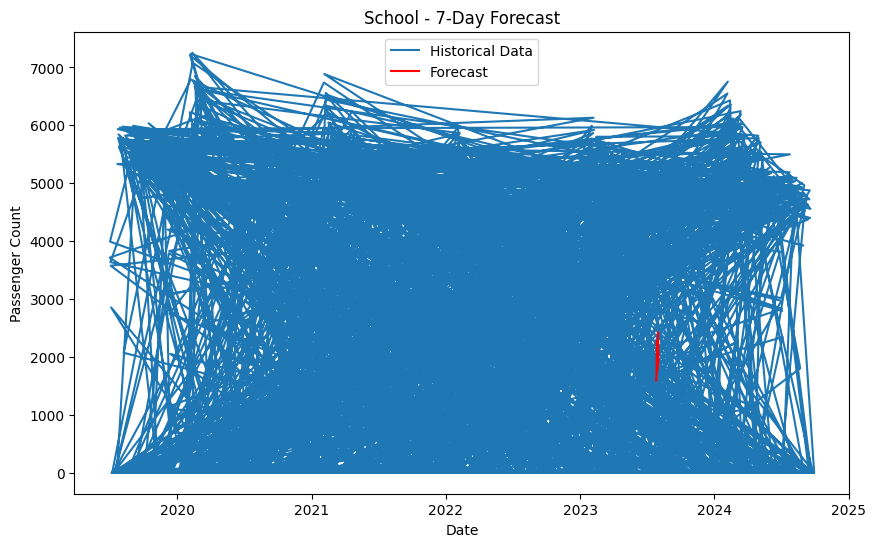

In [46]:
# plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data[service], label='Historical Data')
plt.plot(pd.date_range(data.index[-1], periods=8, freq='D')[1:], forecast, label='Forecast', color='red')
plt.title(f'{service} - 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()

In [47]:
for service, forecast in forecast_results.items():
    print(f"\nForecast for {service} (Next 7 Days):")
    print(forecast)


Forecast for School (Next 7 Days):
1918    1593.224444
1919    1652.476613
1920    2284.949633
1921    1766.640324
1922    1856.512417
1923    2427.653134
1924    1925.888234
Name: predicted_mean, dtype: float64


In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_7_days = test[:7]
# Calculate metrics
mae = mean_absolute_error(test_7_days, forecast)
rmse = np.sqrt(mean_squared_error(test_7_days, forecast))

# Print results
print(f"MAE: {mae}, RMSE: {rmse}")


MAE: 5986.99449570835, RMSE: 8659.602208291291
